# Lagrangian

Following paper

_Introduction to Finite-Difference Methods for Numerical Fluid Dynamics_  
by  
Evan Scannapieco  
Francis Harlow  

Generation of mesh with the following notation

<img src="largrangemeshsys.tiff">
<img src="largrangemesh.tiff">

Such that nodes are denoted \\(j \pm \frac{1}{2} \\) and zones are denoted \\(j \pm 1 \\)



## Step 1

__Find the positon of the right wall of zone, $j$, at the end of the timestep__

Starting with the definition:

$$
\frac{\partial x}{\partial t}=u \\
\frac{x^{n+1}_{j+1/2} - x^{n-1}_{j-1/2}}{\Delta t} = u^{n}_{j+1/2}
$$



Equations to solve:

\begin{align}
u^{n+1}_{j+/2} &= u^{n}_{j+1/2} = \frac{dt}{M}(p^{n}_{j}+q^{n}_{j} - p^{n}_{j+1} - q^{n}_{j+1}) \\
\rho^{n}_{j} &= \frac{M}{x^{n}_{j+1/2} - x^{n}_{j-1/2}} \\
I^{n+1}_i &=I^n_i+\frac{dt}{M}\left(p^n_i + q^n_i \right)\left(u^n_{i-\frac{1}{2}} - u^n_{i+\frac{1}{2}} \right)\\
p^n_j &=\left(\gamma -1 \right)\rho^n_j I^n_j \\
q^n_j &= \left\{\begin{matrix} 
q_0 \rho^n_j c \left(u^n_{i-\frac{1}{2}} - u^n_{i+\frac{1}{2}} \right ) & \text{if positive} \\ 
0 & \text{if negative}
\end{matrix}\right.
\end{align}

Discritization:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from tempfile import NamedTemporaryFile
from IPython.display import HTML

%matplotlib inline

In [2]:
class System(object):
    def __init__(self, x, u, rho, sie, p, q):
        self.x = x
        self.u = u
        self.rho = rho
        self.sie = sie
        self.p = p
        self.q = q
        
dumps = []

In [3]:
xmin = 0.
xmax = 10.
ul = .5
ur = 0.
gamma = 5./3.
jx = 18
rho0 = 1.
sie0 = 0.
q0 = .3

t = 0.
dt = .05
jbar = jx+1
tstop = 10
jxiter = np.arange(1,jbar)

In [4]:
x = np.linspace(xmin, xmax, jbar+1)
u = np.empty(jbar+1); u.fill(ur)
rho = np.empty(jbar); rho.fill(rho0)
sie = np.empty(jbar); sie.fill(sie0)
q = np.empty(jbar); q.fill(0.)
p = np.empty(jbar); p.fill(0.)

M = rho[0]*(x[1]-x[0])

In [5]:
def xn(x, u):
    """Update the position of node j (j+1/2) for a given timestep
    Args
    ----
    x (array) : position  of nodes
    u (array) : velocity of nodes
    j (int) : spatial logic index
    
    Logic
    -----
    xn(j) = x(j) + u(j)dt
    """
    return x + u*dt

In [6]:
def un(u, p, q):
    """Update the velocity of node j for a given timestep
    Args
    ----
    u (array) : velocity of nodes
    p (array) : pressure in zones 
    q (array) : artificial viscious pressure
    j (int) : spatial logic index
    
    Logic
    -----
    un(j) = u(j) + (dt/M) * (p(j-1) + q(j-1) - p(j) - q(j))
    """
    return u[1:-1] + dt/M * (p[:-1] + q[:-1] - p[1:] - q[1:])

In [7]:
def rhon(x):
    """Update density of zone j for given time step
    Args
    ----
    x (array) : position  of nodes
    
    Logic
    -----
    rhon = M (xn(j+1) - xn(j))
    """
    return M / (x[1:] - x[:-1])

In [8]:
def sien(sie, q, p, u):
    """Update internal energy of zone
    Args
    ----
    sie (array) : internal energy
    p (array) : pressure in zones 
    q (array) : artificial viscious pressure
    u (array) : velocity of nodes
    j (int) : spatial logic index
    
    Logic
    -----
    In = I[j] = dt/M (q[j] + p[j]) (u[j]-u[j+1])
    """
    return sie + (dt/M) * (q + p) * (u[:-1] - u[1:])

In [9]:
def pn(rho, sie):
    """Update pressure
    Args
    ----
    sie (array) : internal energy
    rho (array) : density in zones 
    j (int) : spatial logic index

    Logic
    -----
    pn = (gamma-1) * rhon[j] * sien[j]
    """
    return (gamma-1) * rho * sie

In [10]:
def qn(rho, u, sie):
    """Artificial viscious pressure
    Args
    ----
    u (array) : velocity of nodes
    rho (array) : density in zones 
    sie (array) : internal energy (needed to calculate c)
    j (int) : spatial logic index

    Logic
    -----
    qn[j] = q0 * rhon[j] * cn * (un[j] - un[j+1])
    
    q = qn if 
    """
    qn = q0 * rho * c(sie) * (u[:-1] - u[1:])
    qn[qn<0]=0
    return qn


In [11]:
def c(sie):
    """Characteristic velosity
    Only serves to make the equation dimensionally correct
    
    Logic
    ------
    c = piston speed + sound speed of fluid
    sound speed of fluid = ((gamma^2 - gamma)I(j))^(1/2)
    """
    return ul + np.sqrt(gamma*(gamma-1.)*sie)

In [12]:
def piston(t):
    if t<4.:
        return ul
    else:
        return 0

In [13]:
dumps={'rho':[],'pos':[],'pres':[],'visc':[],'vel':[],'c':[]}

dumps['rho'].append(rho.copy())
dumps['pos'].append(x.copy())
dumps['vel'].append(u.copy())
dumps['pres'].append(p.copy())
dumps['visc'].append(q.copy())


#assert False
while t <= 4.:
    u[0] = piston(t)
    u[jx] = ur
    #x[0] = x[0] + u[0]*dt

    x = xn(x, u)
    u[1:-1] = un(u, p, q)
    rho = rhon(x)
    sie = sien(sie, q, p, u)
    p = pn(rho, sie)
    q = qn(rho, u, sie)
        
    """
    if t % 2 == 0:
        dumps.append(system.copy())
    """
    
    t+=dt
    
    if (round(t,2)%1.0==0.0):
        dumps['rho'].append(rho.copy())
        dumps['pos'].append(x.copy())
        dumps['vel'].append(u.copy())
        dumps['pres'].append(p.copy())
        dumps['visc'].append(q.copy())

In [14]:
rho = np.insert(rho, 0, 0)
#xcen = x[:-1] - (x[:-1]-x[1:])/2

(0, 10)

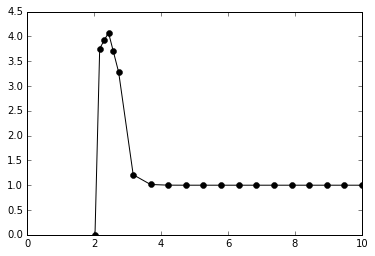

In [15]:
plt.plot(x, rho, 'k-o')
plt.xlim(0,10)

In [16]:
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=5, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    b=np.insert(dumps['rho'][i],0,0)
    a=dumps['pos'][i]
    line.set_data(a,b)
    return line,

In [17]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 10), ylim=(0, 5))
line, = ax.plot([], [], 'k-o', lw=2,)


# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(dumps['rho']), interval=2000, blit=True)

# call our new function to display the animation
display_animation(anim)